For this project, code for grabbing post data from Weibo via spider is not include in this notebook. We ran the code on our local computer instead of colab. 

Import libraries

In [ ]:
!pip install stanza
import stanza
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from pandas.io.excel import read_excel
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import matplotlib
import tmtoolkit
import nltk
import random
import numpy as np
from tmtoolkit.corpus import Corpus
import json
import pickle
import scipy.sparse
import pandas as pd
import jieba
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities

import pyLDAvis
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19546 sha256=5ed781f89141141aea24b965a68e234b436d8a269b23bc2fc5ad6b85198fc082
  Stored in directory: /root/.cache/pip/wheels/50/22/42/1d5dc43faf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=4b157e658ed81415b3a4af9abf6209c2e519c94548b9d0214c5d7a206879d169
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


Read the Post data which is obtained via spider

In [ ]:
# Load the CSV file into a pandas dataframe
df_train = pd.read_csv("blog_weibo.csv")

# Select "text" and "time" which are important for analysis from the spider dataset
feature = ['微博正文', '发布时间']
train_data_copy = df_train.copy() 
df = train_data_copy[feature] 
df = df.rename(columns={"微博正文": "text", "发布时间": "time"}) # Rename two columns

# Save the resulting dataframe to 'ShanghaiPreNLP.csv'
df.to_csv('ShanghaiPreNLP.csv', index=False)


'2022-08-08'

Carry out NLP and save the result to "ShanghaiAfterNLP.xlsx"

In [ ]:
# Initialize the NLP pipeline with the Chinese language and the tokenize and sentiment processors
nlp = stanza.Pipeline(lang='zh', processors='tokenize,sentiment')

# Loop through each row of the dataframe and apply sentiment analysis to Post data
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Use the NLP pipeline to tokenize the text and get the sentiment scores for each sentence
    n = nlp(row['text']).sentences
    sen = 0
    for j in range(len(n)):
        sen += n[j].sentiment
    # Calculate the average sentiment score for the post
    sen = sen / len(n)
    df.at[i, 'sentiment'] = sen
    
# Export the updated dataframe to 'ShanghaiAfterNLP.xlsx'
df.to_excel('ShanghaiAfterNLP.xlsx', index=False)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:"zh" is an alias for "zh-hans"
INFO:stanza:Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| sentiment | ren     |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: sentiment
INFO:stanza:Done loading processors!
100%|██████████| 39804/39804 [47:08<00:00, 14.07it/s]


Combine Weather data and Post Data

In [ ]:
df=read_excel("ShanghaiAfterNLP.xlsx")
dfw=pd.read_csv("shanghai_weather.csv")

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
# Split the 'time' and selete the date
    df.at[i, 'time'] = row['time'].split()[0]

df

100%|██████████| 39804/39804 [00:06<00:00, 5924.53it/s]


,text,time,sentiment
0,喜欢色戒和罗曼蒂克消亡史这两部，看看过去的上海，不仅感慨经典已成过去，罗曼蒂克消亡矣……最近...,2022-08-08,2.000000
1,【高温橙色预警！明天，#陕西湖北重庆等局地将达40度#】预计9日，陕西、河南、安徽、江苏、上...,2022-08-08,0.666667
2,现在逛商场好幸福，因为哈尔滨的天气现在已经要穿长袖长裤了，所以短袖T恤连衣裙都会打折，但是回...,2022-08-10,2.000000
3,上海这BT的天气，没有一丝丝风，即使到半夜还汗流浃背，要知道我是个不怎么出汗的人呀,2022-08-09,0.000000
4,跑团上个月就已经成立三周年了，由于疫情的影响，想搞个活动庆祝一下也没法弄。总算等到上海疫情清...,2022-08-08,1.000000
...,...,...,...
39799,晚饭之后一顿压马路现在终于躺在床上挑这首歌作为今天的总结上海现在的天气太适合白天骑车晚上压马路了,2022-09-12,2.000000
39800,#市民盲目放生致苏州河现大量死鱼#近日，上海苏州河上频现大量死鱼。据上海市市容环境卫生水上管...,2022-08-25,1.000000
39801,天气凉得好快呀睡觉盖夏凉被已经开始不暖和了,2022-08-23,0.000000
39802,#上海天气#今天好凉快啊我好开心,2022-08-24,2.000000


Split the Post Data prepare for wordcloud using "jieba" library

In [ ]:

data=df
t=''
for index, row in tqdm(data.iterrows()):
    t+=str(row['text'])
    t+=' '
seg_list = jieba.cut(t, cut_all=False)
#for i in ['的','了','是','和','在','有','这','会','也','还','被','把','#','，','！','？','。','【'，'】','《','》']:
#  while i in l:
#   l.remove(i)

# Tokenize and segment the post text in t 
seg_list = jieba.cut(t, cut_all=False)

# Join the segmented text back into a single string, separated by spaces
text = ' '.join(seg_list)

39804it [00:04, 9210.24it/s] 
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.814 seconds.
DEBUG:jieba:Loading model cost 0.814 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
with open("output.txt", "w",encoding="utf-8") as file:
    file.write(text)

Preprocess the dataset and prepare for the training of the model

In [ ]:

# Drop some features (model training failed a lot of times and prof recommand to try to drop some features and train again)
dfw1 = dfw.drop(['name', 'description', 'icon', 'stations', 'preciptype', 'sunrise', 'sunset'], axis=1)

# Remove duplicate parts in text
df1 = df.drop_duplicates(subset='text', keep='first')

# Combine Post data and Weather data
df2 = df1.drop(['text'], axis=1)
dff = pd.merge(df2, dfw1, how='left', left_on='time', right_on='datetime')

dff = dff.drop(['datetime'], axis=1)

# One-hot encode the conditions
dff0 = pd.get_dummies(dff.conditions, prefix='conditions')
dff = pd.concat([dff, dff0], axis=1)
dff = dff.drop(['conditions'], axis=1)
dff = dff.sample(frac=1)

# Split the dataset into input features and output labels
x = dff.drop(['time', 'sentiment'], axis=1)
y = pd.DataFrame(dff['sentiment'])

# Standardize
scaler = StandardScaler()
xs = scaler.fit_transform(x)

# Normalize the output label
scaler1 = MinMaxScaler()
ys = scaler1.fit_transform(pd.DataFrame(y))

x

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,uvindex,severerisk,moonphase,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain, Ice, Partially cloudy"
10246,12.4,1.8,7.1,12.4,-0.3,5.6,-3.3,52.6,0.0,0,...,8,10,0.00,1,0,0,0,0,0,0
29062,27.2,20.2,22.9,27.4,20.2,22.9,15.4,63.3,0.0,0,...,6,10,0.98,0,0,1,0,0,0,0
33577,31.2,24.8,27.6,37.5,24.8,30.5,24.8,85.0,4.6,100,...,6,30,0.25,0,0,0,0,0,1,0
6082,17.8,4.2,11.8,17.8,2.3,10.8,5.4,67.7,0.0,0,...,8,10,0.26,0,0,1,0,0,0,0
33148,28.0,25.3,26.7,31.2,25.3,27.9,21.9,75.4,16.0,100,...,2,10,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26016,26.0,23.3,24.7,26.0,23.3,24.7,23.9,95.4,42.0,100,...,2,10,0.62,0,0,0,0,1,0,0
8631,11.7,4.0,9.2,11.7,1.9,8.0,2.8,66.0,0.1,100,...,7,10,0.96,0,0,0,0,0,1,0
33235,27.8,24.2,25.6,29.7,24.2,26.0,20.7,74.9,2.8,100,...,3,10,0.21,0,0,0,0,0,1,0
27549,22.2,12.8,17.7,22.2,12.8,17.7,10.2,62.6,0.0,0,...,8,10,0.83,0,0,1,0,0,0,0


Visualize the Combined data via PCA

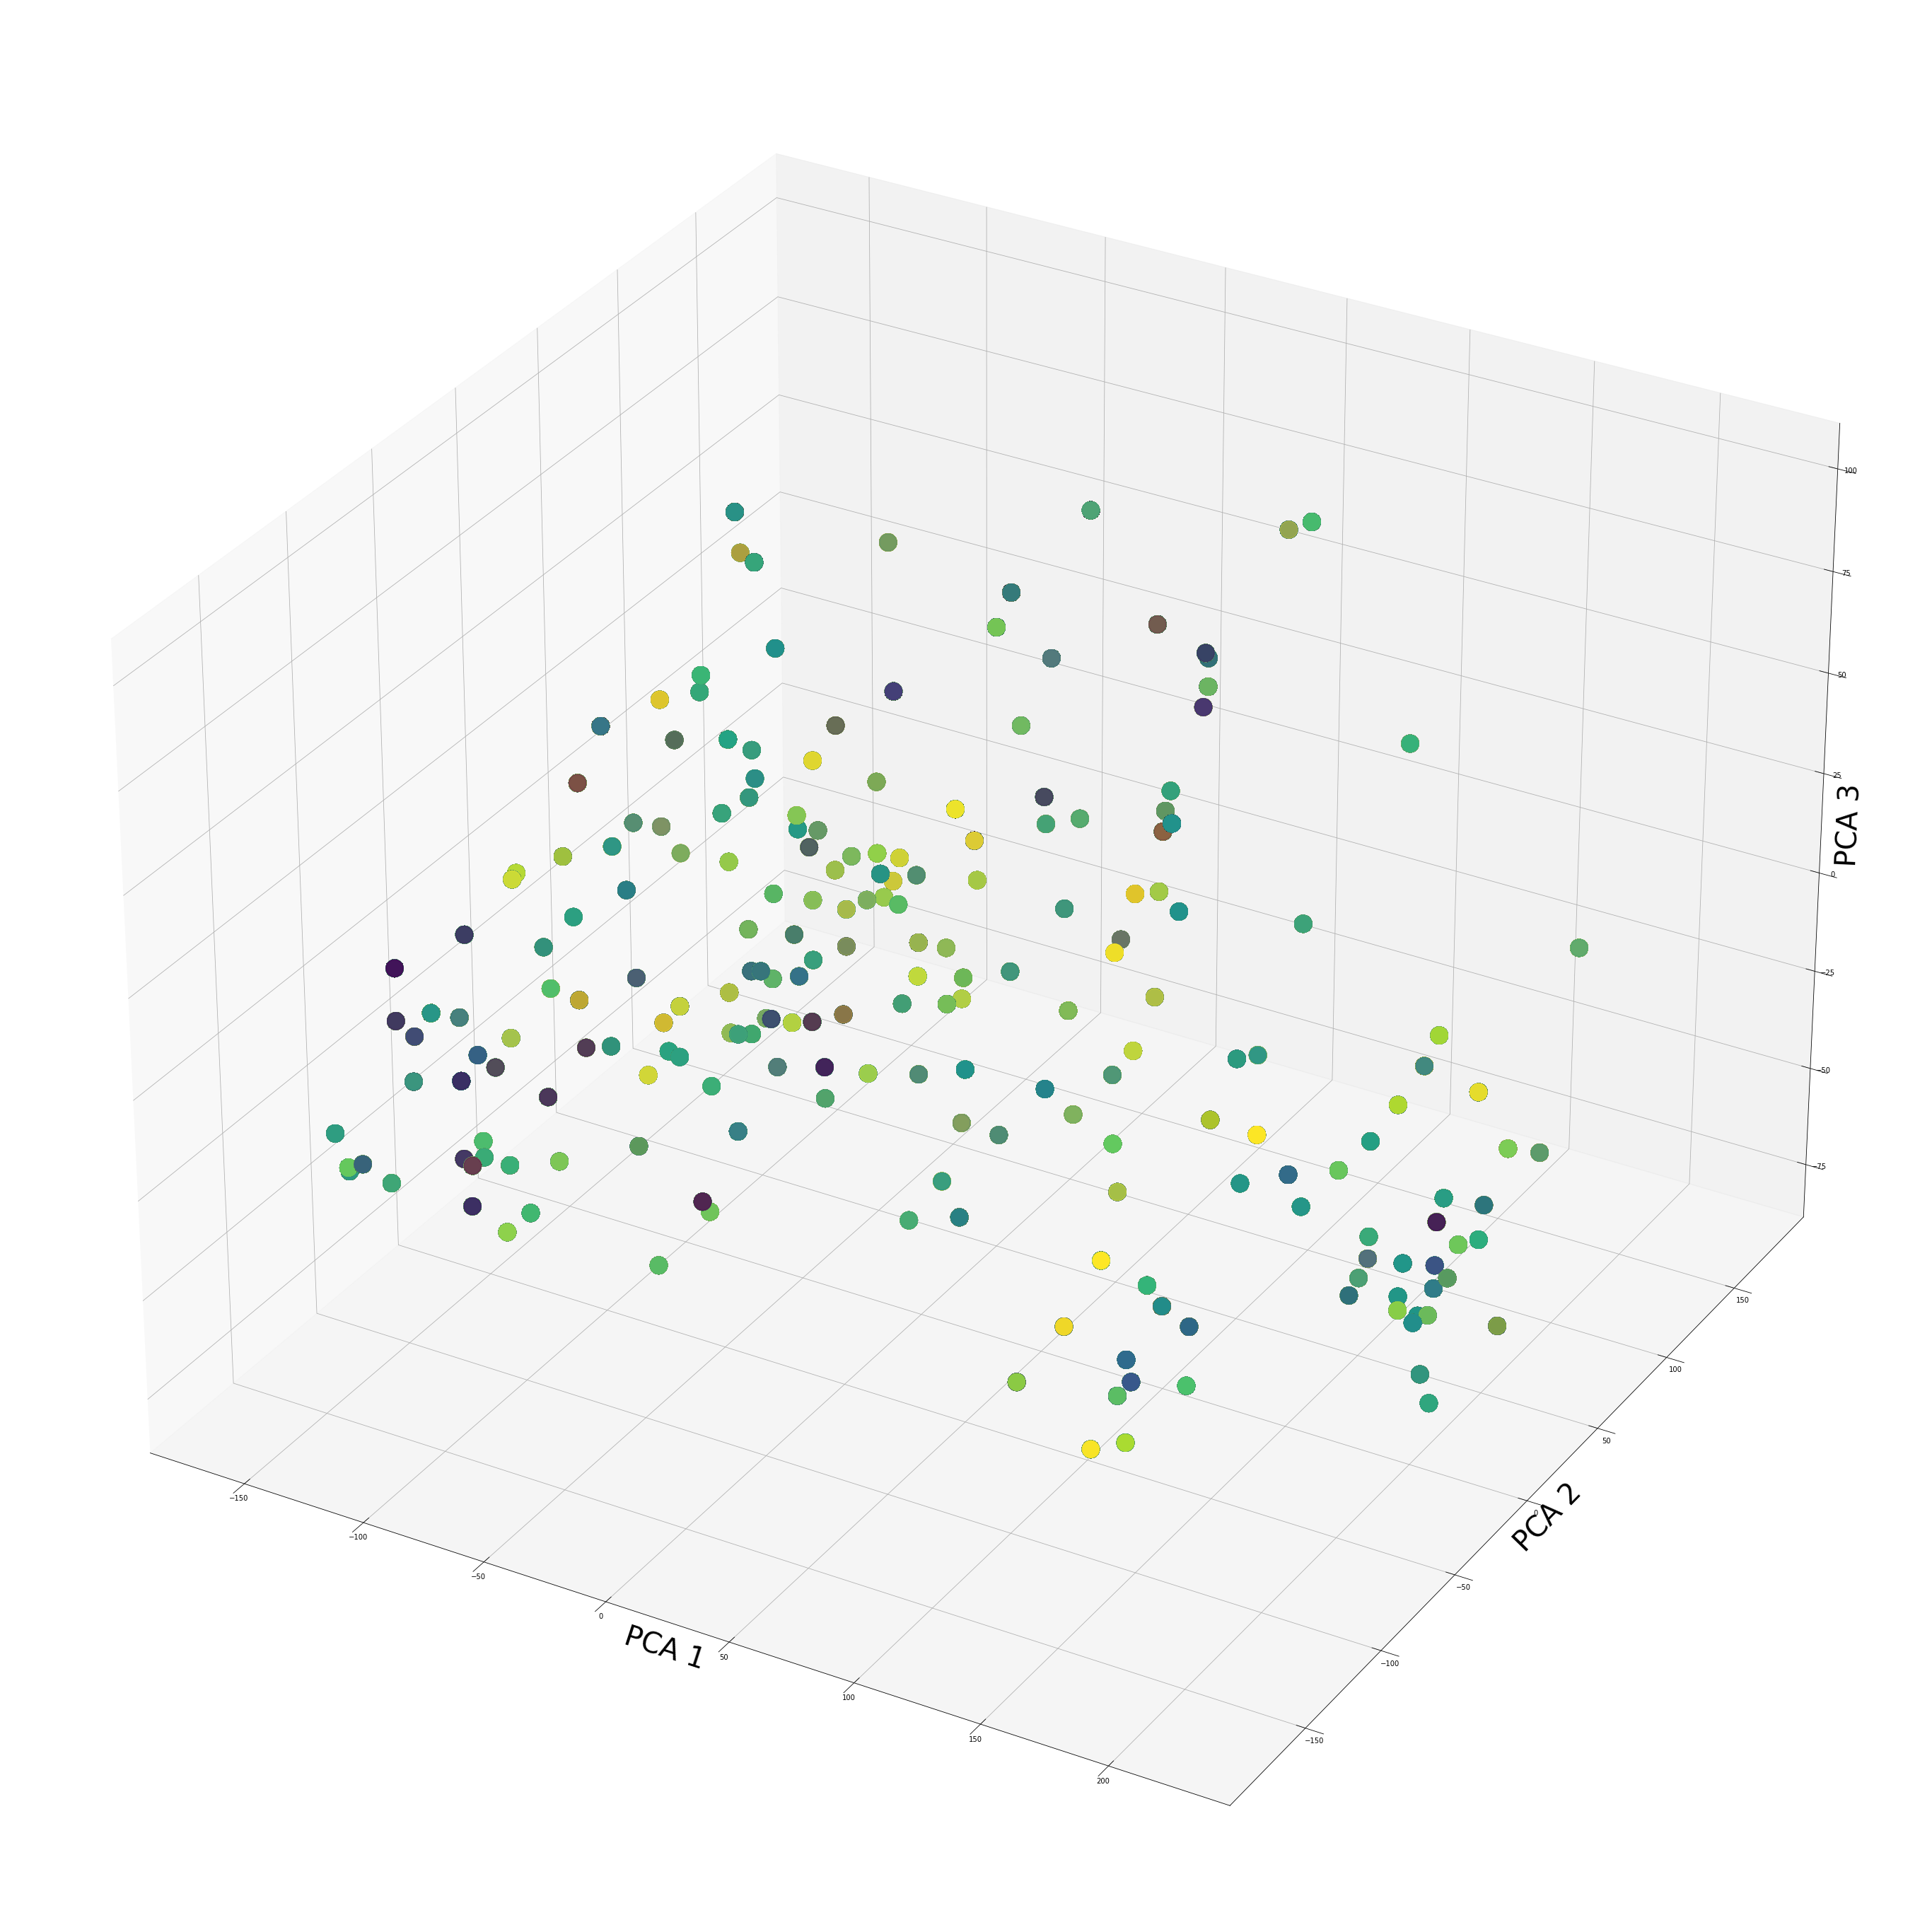

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
X = pca.fit_transform(x)
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PCA 1',fontsize = 40)
ax.set_ylabel('PCA 2',fontsize = 40)
ax.set_zlabel('PCA 3',fontsize = 40)
ax.scatter(X[:,0] ,X[:,1], X[:,2],c=y,s=[600 for i in range(len(y))])

Split the dataset into train set and test set with the proportion 8:2

---



In [ ]:
from sklearn.model_selection import train_test_split

# Split x into x_train and x_test with a 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training data shape:", x_train.shape) 
print("Testing data shape:", y_test.shape) 


Training data shape: (31843, 31)
Testing data shape: (7961, 1)


Calculate corelation matrix

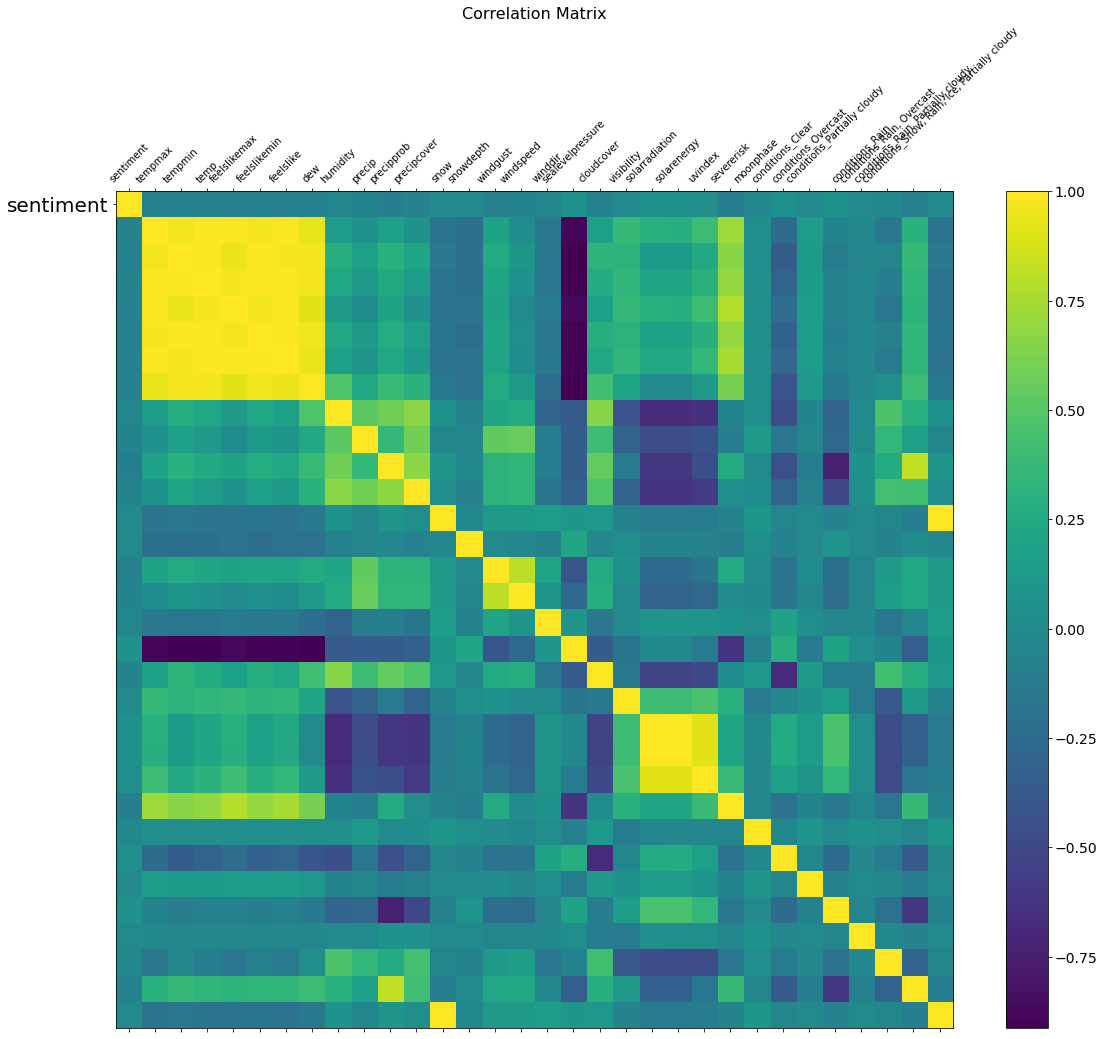

In [ ]:
df=dff
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(1), pd.DataFrame(df['sentiment']).select_dtypes(['number']).columns, fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Neural Network trial

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,BatchNormalization, Activation, Dropout

xs=scaler.fit_transform(x[['temp','humidity','conditions_Clear',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow, Rain, Ice, Partially cloudy']])
xs = xs.reshape(-1,9,1)
xs.shape
ys.shape

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(9,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='softmax'))

model.compile(loss='mse',optimizer='Adam',metrics=['accuracy'])

history=model.fit(xs, ys,  steps_per_epoch=x_train.shape[0]//50,epochs=50)
#loss,acc = model.evaluate(x_test, y_test)
#print("Test accuracy:",acc)

Epoch 1/50
636/636 [==============================] - 6s 5ms/step - loss: 0.2778 - accuracy: 0.1991
Epoch 2/50
636/636 [==============================] - 4s 7ms/step - loss: 0.2778 - accuracy: 0.1989
Epoch 3/50
636/636 [==============================] - 3s 5ms/step - loss: 0.2777 - accuracy: 0.1990
Epoch 4/50
636/636 [==============================] - 3s 5ms/step - loss: 0.2774 - accuracy: 0.1993
Epoch 5/50
636/636 [==============================] - 3s 5ms/step - loss: 0.2784 - accuracy: 0.1988
Epoch 6/50
636/636 [==============================] - 4s 6ms/step - loss: 0.2770 - accuracy: 0.1995
Epoch 7/50
636/636 [==============================] - 3s 5ms/step - loss: 0.2780 - accuracy: 0.1985
Epoch 8/50
636/636 [==============================] - 4s 6ms/step - loss: 0.2782 - accuracy: 0.1985
Epoch 9/50
636/636 [==============================] - 4s 6ms/step - loss: 0.2772 - accuracy: 0.1996
Epoch 10/50
636/636 [==============================] - 4s 6ms/step - loss: 0.2779 - accuracy: 0.1989

636/636 [==============================] - 2s 3ms/step - loss: 0.2779 - accuracy: 0.1987


In [ ]:
xx=x[['temp','humidity']]
yy=y['sentiment'].ravel()
yy.shape

Linear Regression trial

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(xx[:1000], yy[:1000])
reg.score(xx[1000:1100],yy[1000:1100])


-0.07011898259830796

Desicion Tree trial

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf=clf.fit(xx[:1000], yy[:1000])
clf.score(xx[1000:1100],yy[1000:1100])

-0.3595906224172809

SVR trial

In [ ]:
from sklearn import svm
regr = svm.SVR()
regr=regr.fit(xx[:1000], yy[:1000])
regr.score(xx[1000:1100],yy[1000:1100])

-0.06851895366232941

Wordcloud visualization (implement later on on our local computer instead of colab)

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text= open("output.txt").read()

font = r'simfang.ttf'
wc = WordCloud(collocations=False, font_path=font, width=1400, height=1400, margin=2).generate(text.lower())

plt.imshow(wc)
plt.axis("off")
plt.show()

wc.to_file('show_Chinese.png') 


NotImplementedError: ignored

Calculate the top 10 most frequent words in Post Data

In [ ]:
import collections
fn = open('output.txt', 'r', encoding='utf-8') 
string_data = fn.read() 
fn.close() #
pattern = re.compile(u'\t|\n|\.|-|:|;|\)|\(|\?|"') 
string_data = re.sub(pattern, '', string_data) 
seg_list_exact = jieba.cut(string_data, cut_all = False) 
object_list = []

#Remove some useless words from counting
remove_words = [u'的', u'，',u'和', u'是', u'随着', u'对于', u'对',u'等',u'能',u'都',u'。',u' ',u'、',u'中',u'在',u'了',
                u'通常',u'如果',u'我们',u'需要',u'我',u'#',u'有',u'：',u'“',u'”',u'也',u'！',u'到',u'将',u'就',u'不'] 
for word in tqdm(seg_list_exact):
  if word not in remove_words and len(word)>1: 
      object_list.append(word) 

word_counts = collections.Counter(object_list)
word_counts_top10 = word_counts.most_common(30) 
print (word_counts_top10) 
word_counts_top10 = str(word_counts_top10)


15355919it [02:50, 90288.32it/s] 


[('上海', 55446), ('天气', 48813), ('今天', 19644), ('气温', 16636), ('高温', 14683), ('影响', 12796), ('##', 12497), ('一个', 12002), ('10', 11797), ('地区', 10937), ('没有', 10798), ('台风', 9760), ('自己', 9635), ('最高', 9588), ('12', 9479), ('视频', 8995), ('浙江', 8991), ('可以', 8844), ('11', 8539), ('明天', 8523), ('中国', 8497), ('南部', 8137), ('部分', 7926), ('出现', 7905), ('发布', 7706), ('东部', 7645), ('预计', 7640), ('预警', 7606), ('北部', 7395), ('就是', 7373)]
